# Partial Correlations and Directed Acyclic Graphs

In [1]:
import random
import numpy as np
import pandas as pd

import numpy as np
import pandas as pd
length = 10000
cols = ["P", "Q", "X", "Y", "Z"]
mu = 0
sigma = 5


import pingouin
lst_dct = {col:[] for col in cols }
for i in range(length):
    lst_dct["P"].append(25 + np.random.normal(mu, .5 * sigma))
    lst_dct["Q"].append(50 + np.random.normal(mu, sigma))
    lst_dct["X"].append(3 * lst_dct["Q"][-1]  + np.random.normal(mu, sigma ))
    lst_dct["Y"].append(lst_dct["Q"][-1] * -0.5  +  np.random.normal(mu, sigma))
    lst_dct["Z"].append(lst_dct["P"][-1] * 2 +  1.5 * lst_dct["X"][-1] -  lst_dct["Y"][-1] * 2 +  np.random.normal(mu,  sigma))

df = pd.DataFrame(lst_dct)
keys = cols 
# ["Q",
#         "X",
#         "Y",
#         "Z"]
dag_keys = keys 
df

,P,Q,X,Y,Z
0,27.120939,44.797561,128.074186,-23.928755,302.867951
1,19.630667,51.976746,149.270296,-19.115866,310.848068
2,25.571404,50.094882,150.968038,-25.605904,333.305388
3,25.718051,47.362619,148.402008,-26.791672,327.272376
4,27.474946,47.125993,146.048075,-10.758083,297.535829
...,...,...,...,...,...
9995,16.841143,51.426430,156.961550,-21.597508,304.371877
9996,25.480436,51.449836,140.492701,-22.556556,317.124878
9997,26.206387,57.770796,167.908916,-31.060997,359.747294
9998,27.163143,51.389017,156.234552,-17.559640,316.529665


Obviously, these variables are correlated. Variables X, Y, and Z all descend from Q. X and Y are direct descendant whereas Z is a descendant of X and Y. We can view all of these correlation in a single plot.

<AxesSubplot:xlabel='Q', ylabel='Z'>

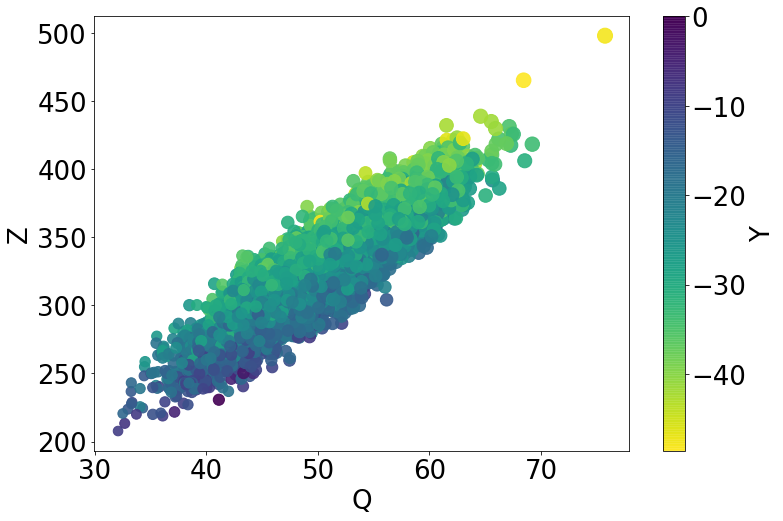

In [8]:
import matplotlib.pyplot as plt
# We can visualize the correlation of these variables on four dimensions:
#     2 dimensions in x-y space, a 3rd dimension using size and a fourth using color
plt.rcParams.update({"font.size":26})
fig, ax = plt.subplots(figsize = (12,8))
df.plot.scatter(x = "Q", y = "Z", c = "Y",s = "X", cmap = "viridis_r",alpha = .9, ax = ax)

In [3]:
df.corr()

,P,Q,X,Y,Z
P,1.000000,-0.002615,-0.000045,0.005874,0.163058
Q,-0.002615,1.000000,0.946803,-0.451471,0.883274
X,-0.000045,0.946803,1.000000,-0.429467,0.916494
Y,0.005874,-0.451471,-0.429467,1.000000,-0.688460
Z,0.163058,0.883274,0.916494,-0.688460,1.000000


# Partial Correlation

All of the variables appear to be correlated. Yet, we should be suspicious of the correlation between Z and Q. Q does not cause Z directly. Its causal effect on Z is intermediated by X and Y. Likewise, X and Y appear to be strongly correlated, but we know that these variables do not cause one another. They have a common cause.

To calculate correlation between two variables while controlling for the effects of the remaining variables, we calculate the partial correlation. For example, the partial correlation of Q and X is an estimate of the joint probability $P(Q,X|Y,Z)$.

In [4]:
import pingouin
df.pcorr()

,P,Q,X,Y,Z
P,1.000000,-0.000657,-0.594132,0.641090,0.714709
Q,-0.000657,1.000000,0.518606,-0.074294,-0.006006
X,-0.594132,0.518606,1.000000,0.745656,0.835376
Y,0.641090,-0.074294,0.745656,1.000000,-0.894671
Z,0.714709,-0.006006,0.835376,-0.894671,1.000000


We see that the partial correlation of Q and X is 

In [5]:
df[["Q", "X", "Y"]].pcorr()


,Q,X,Y
Q,1.000000,0.934356,-0.154326
X,0.934356,1.000000,-0.007008
Y,-0.154326,-0.007008,1.000000


In [6]:

undirected_graph = {key:[] for key in df.keys()}
for x in undirected_graph:
    remaining_vars = [y for y in df.keys() if y != x]
    for y in remaining_vars:
        undirected_graph[x].append(y)

undirected_graph           

{'P': ['Q', 'X', 'Y', 'Z'],
 'Q': ['P', 'X', 'Y', 'Z'],
 'X': ['P', 'Q', 'Y', 'Z'],
 'Y': ['P', 'Q', 'X', 'Z'],
 'Z': ['P', 'Q', 'X', 'Y']}

In [7]:
import copy
import pingouin
p_val = .01
def build_skeleton(df, undirected_graph):    
    def check_remaining_controls(control_vars, undirected_graph, x, y, controls_used) :
        c_used = copy.copy(controls_used)
        for c_var in control_vars:
            if y not in undirected_graph[x]:
                break
            c_used.append(c_var)
            test = df.partial_corr(x = x, y = y, covar=c_used,
                                  method = "pearson")
            if test["p-val"].values[0] > p_val: 

                undirected_graph[x].remove(y)
                #breakout of the for 
                break
            else:
                remaining_controls = copy.copy(control_vars)
                remaining_controls.remove(c_var)
                check_remaining_controls(remaining_controls, undirected_graph, x, y, c_used)
    d_sep = {}
    for x in df.keys():
        ys = undirected_graph[x]
        for y in df.keys():
            d_sep[(x,y)] = []

            if x != y:
            # first check for correlation with no controls
                test = df.partial_corr(x = x, y = y, covar = None,method = "pearson") 
                if test["p-val"].values[0] > p_val:
                    undirected_graph[x].remove(y)
            # if correlated check for deseparation controlling for other variables
                else:
                ############## make recursive function #############

                    control_vars = [z for z in df.keys() if z != y and z != x]
                    check_remaining_controls(control_vars, undirected_graph, x, y, [])
    return undirected_graph

undirected_graph = build_skeleton(df, undirected_graph)                                   
undirected_graph

{'P': ['Z'],
 'Q': ['X', 'Y'],
 'X': ['Q', 'Z'],
 'Y': ['Q', 'Z'],
 'Z': ['P', 'X', 'Y']}

In [8]:
import matplotlib.pyplot as plt
import networkx as nx
def graph_DAG(undirected_graph, df, title = "DAG Structure"):
    
    # generate partial correlation matrix to draw values from
    # for graph edges
    pcorr_matrix = df.pcorr()
    graph = nx.Graph()
    edges = []
    edge_labels = {}
    for key in undirected_graph:
        for key2 in undirected_graph[key]:
            if (key2, key) not in edges:
                edge = (key.replace(" ","\n"), key2[0].replace(" ","\n"))
                edges.append(edge)
                # edge label is partial correlation between
                # key and key2
                edge_labels[edge] = str(round(pcorr_matrix.loc[key][key2],2))

    # edge format: ("i", "j") --> from node i to node j
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, 
                     node_size = 1000,
                     with_labels=True,  arrows=False,
                     font_size = 20, alpha = 1,
                     font_color = "white",
                     ax = ax)
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20)
    plt.axis("off")
    plt.savefig("g1.png", format="PNG")
    # tell matplotlib you're done with the plot: https://stackoverflow.com/questions/741877/how-do-i-tell-matplotlib-that-i-am-done-with-a-plot
    plt.show()


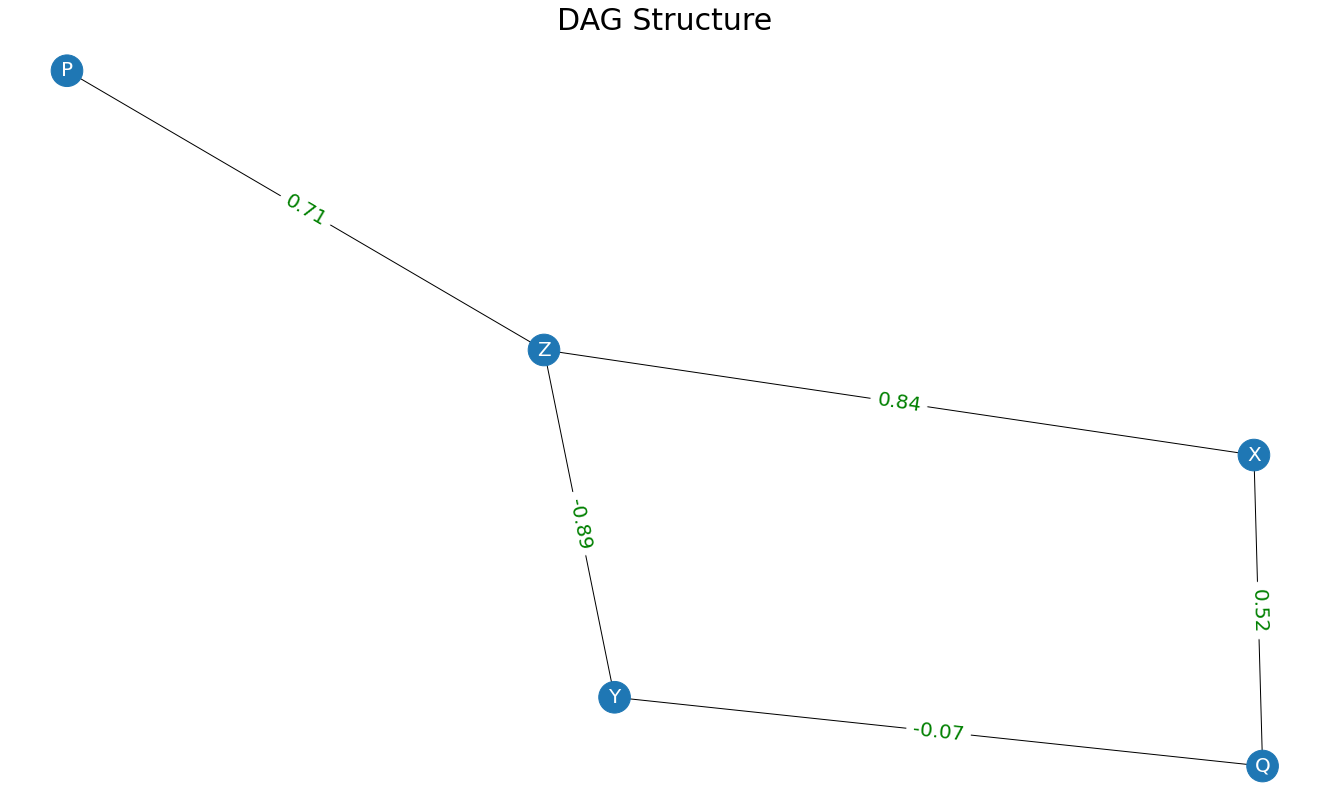

In [9]:
graph_DAG(undirected_graph, df, title = "DAG Structure")

In [10]:
from pgmpy.estimators import PC
c = PC(df)
max_cond_vars = len(dag_keys) - 2


model = c.estimate(return_type = "dag",variant= "parallel", 
                   significance_level = p_val, 
                   max_cond_vars = max_cond_vars, ci_test = "pearsonr")
edges = model.edges()
pcorr = df.pcorr()
weights = {}
for edge in edges:
    print(edge, ":",pcorr[edge[0]].loc[edge[1]])
    

Working for n conditional variables: 3: 100%|████████████████████████████████████████████| 3/3 [00:00<00:00,  7.82it/s]C:\Users\JLCat\anaconda3\lib\site-packages\pgmpy\estimators\PC.py:369: UserWarning: Reached maximum number of allowed conditional variables. Exiting
  warn("Reached maximum number of allowed conditional variables. Exiting")
Working for n conditional variables: 3: 100%|████████████████████████████████████████████| 3/3 [00:00<00:00,  6.98it/s]


('Y', 'Z') : -0.894671263897142
('P', 'Z') : 0.7147090395257959
('X', 'Z') : 0.8353756110502231
('Q', 'Y') : -0.07429435356506375
('Q', 'X') : 0.5186063192095539


keep control: P
keep control: X
('Y', 'Z') ['P', 'X']
keep control: X
keep control: Y
('P', 'Z') ['X', 'Y']
keep control: P
keep control: Y
('X', 'Z') ['P', 'Y']
('Q', 'Y') []
('Q', 'X') []


OutEdgeView([('Y', 'Z'), ('P', 'Z'), ('X', 'Z'), ('Q', 'Y'), ('Q', 'X')])

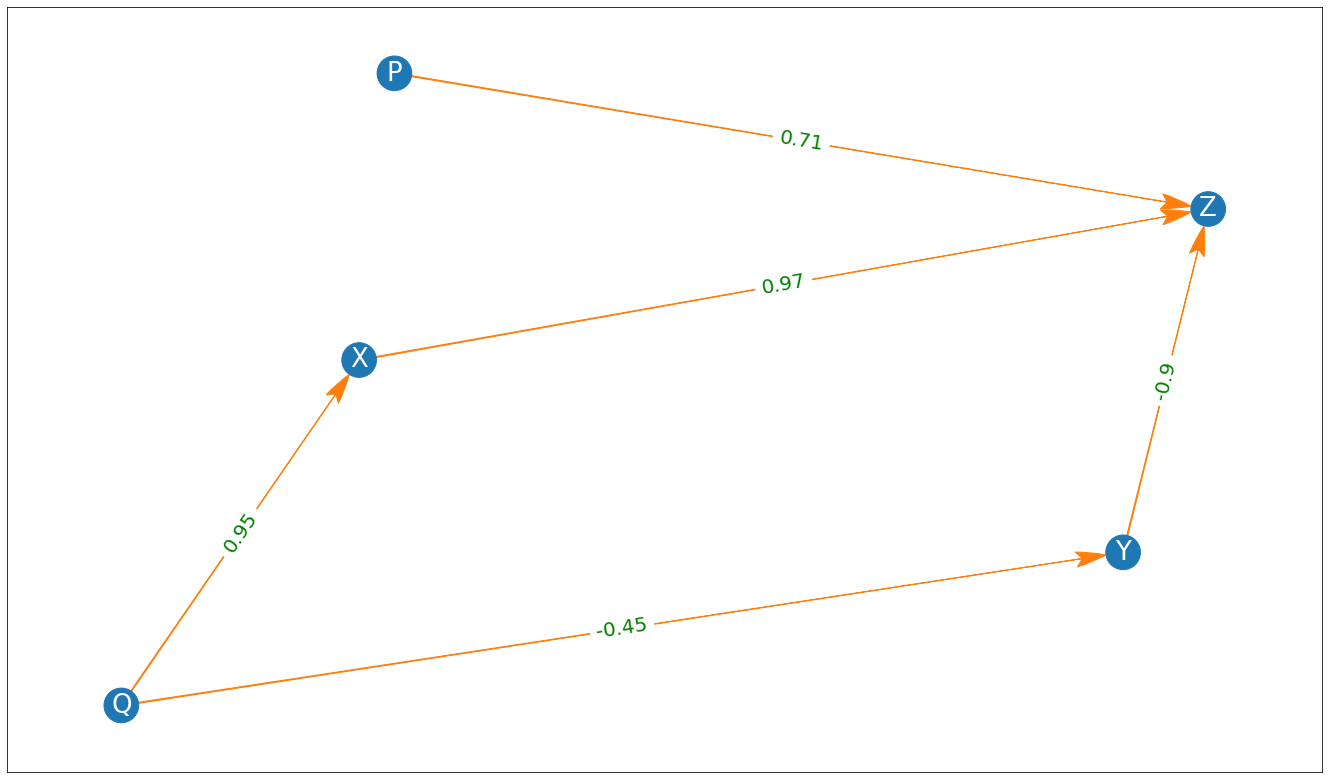

In [11]:
from matplotlib.patches import ArrowStyle

def graph_DAG(edges, df, title = ""):
    graph = nx.DiGraph()
    edge_labels = {}
    for edge in edges:
        controls = [key for key in df.keys() if key not in edge]
        controls = list(set(controls))
        keep_controls = []
        for control in controls:
            control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
            if (control, edge[1]) in control_edges:
                print("keep control:", control)
                keep_controls.append(control)                
        print(edge, keep_controls)
        pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
        edge_labels[edge] = str(round(pcorr[edge[0]].loc[edge[1]],2))
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     font_color = "white",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)
    nx.draw_networkx_edge_labels(graph,pos,
                                edge_labels=edge_labels,
                                font_color='green',
                                font_size=20)

graph_DAG(edges, df)
edges

In [12]:
df[["X","Y", "Z"]].pcorr()

,X,Y,Z
X,1.000000,0.694487,0.947846
Y,0.694487,1.000000,-0.816149
Z,0.947846,-0.816149,1.000000
